スタッキングしてみる

In [1]:
%matplotlib inline
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
from scipy import stats
from hyperopt import fmin, tpe, hp, rand

from sklearn.decomposition import PCA, KernelPCA
from sklearn import svm
from sklearn import model_selection

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge

In [2]:
# 波形の可視化
def viz_signal(X_viz_train, y_viz_train=None, X_on_draw=None, ymin=1.3, ymax=1.7):
    label_flg = False
    draw_flg = False
    if y_viz_train is not None:
        label_flg = True
    if X_on_draw is not None:
        draw_flg = True
        
    for i, x in enumerate(X_viz_train):
        plt.subplot(len(X_viz_train),1, i+1)
        plt.plot(x)
        
        # 上に書くなら
        if draw_flg:
            plt.plot(X_on_draw[i])
            
        plt.xlim(0,len(x))
        plt.ylim(ymin, ymax)
        
        if label_flg:
            plt.ylabel(int(y_viz_train[i]), fontsize=8)
        else:
            plt.ylabel(i, fontsize=8)  
    plt.show()

# ゼロを中央値に置き換える
def zero2median(X):
    dvs = []
    for xs in X:
        xs[np.isnan(xs)] = np.nanmedian(xs)
        dvs.append(xs)
    return np.array(dvs)

# 波形データを分割してシャッフル
def data_generator(X_, y_=None, w_size = 4096, offset = 500):
    if y_ is None:
        # ラベルがないとき(test)
        X_sub = []
        for n, x in enumerate(X_):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
        return np.array(X_sub)
    else:
        # ラベルがあるとき(train)
        X_sub, y_sub = [], []
        for n, (x, y) in enumerate(zip(X_, y_)):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
                y_sub.append(y)
        X, y = np.array(X_sub), np.array(y_sub)
        # データをシャッフルする
        data_size = len(y)
        shuffle_idx = random.sample(range(data_size), k=data_size) 
        return X[shuffle_idx], y[shuffle_idx] 


# 標準偏差が閾値内なら使用する
def data_selection_std(X_, y_, th_max=0.3, th_min=0.001):
    X, y = [], []
    for (xp, yp) in zip(X_, y_):
        if np.std(xp) > th_min and np.std(xp) < th_max:
            X.append(xp)
            y.append(yp)
        #else:
        #    print(xp, np.std(xp))

    return np.array(X), np.array(y)

# フーリエ変換
def transform_fft(X_):
    # サンプル長
    N = X_.shape[1]
    X_fft = []
    for x in X_:
        # 高速フーリエ変換
        win = hamming(N)
        F = np.fft.fft(x*win)#/(N/2)
        # 直流成分の振幅を揃える
        # F[0] = F[0]/2
        #amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in F]
        # なぜか実部だけの方が予測性能がいい
        amp = [c.real  for c in F]
        # ナイキスト周波数の範囲内のデータのみ取り出し
        X_fft.append(amp[0:int(N/2)-1])
    return np.array(X_fft)

# 平滑化フィルタ
def savgol(X):
    X_ = []
    for xf in X:
        x_f = signal.savgol_filter(xf, 21, 3, mode="mirror")
        X_.append(x_f) 
    return np.array(X_)

# データの前処理
def data_preproc(X_, y_=None, datalen=None):
    if y_ is not None:
        X_pre, y_pre = data_generator(X_, y_, w_size=datalen, offset=datalen-1)
        X_d, y_d = data_selection_std(X_pre, y_pre) 
        X_f = savgol(X_d)
        X_fft = transform_fft(X_f)
        return X_fft, y_d     
    else:
        X_pre = data_generator(X_, w_size=datalen, offset=datalen-1)
        X_f = savgol(X_pre)
        X_fft = transform_fft(X_f)
        return X_fft

# 次元圧縮
def data_sequence(X_, dim=16, kernel_pca='rbf'):
    # 標準化1
    X_std_ = stats.zscore(X_, axis=1)
    # 主成分分析
    pca = KernelPCA(n_components=int(dim), kernel=kernel_pca)
    X_pca_ = pca.fit_transform(X_std_)
    #標準化2
    X_std2_ = stats.zscore(X_pca_, axis=1)
    return X_std2_   

# 任意の個数にデータを分ける (split, term, dim)
def k_fold_data(X_, y_=None, n_split=10):
        n_term = X_.shape[0] // n_split
        X = X_[:n_term*n_split]
        X = X.reshape(n_split, n_term, X_.shape[1])
        if y_ is not None:
            y = y_[:n_term*n_split]
            y = y.reshape(n_split, n_term)
            return X, y     
        return X   

# 交差検定みたいな X_.shape=(k, n, d), y_shape=(k, n)
def k_fold_separate(X_, y_, k_idx=0):
    X_set = np.empty((0, X_.shape[2]), float)
    y_set = np.empty((0,), float)
    for i, (X, y) in enumerate(zip(X_, y_)):
        if i == k_idx:
            continue
        else:
            X_set = np.append(X_set, X, axis=0)
            y_set = np.append(y_set, y, axis=0)            
    return (X_set, y_set, X_[k_idx].reshape(-1, X_.shape[2]), y_[k_idx].reshape(-1,))

In [54]:
# パラメータ置き場

model_name_set = ['svr', 'rfr', 'gbr', 'brr']

estimators = [10, 50, 100, 500, 1000]
features = ['auto','sqrt','log2']

space ={
    'rfr':[
        hp.choice('n_estimators', [i for i in range(len(estimators))]),
        hp.choice('max_features', [i for i in range(len(features))]),
        hp.uniform('min_samples_split', 2, 10),
        hp.uniform('max_depth', 2, 10)
    ],
    'gbr':[
        hp.choice('n_estimators', [i for i in range(len(estimators))]),
        hp.choice('max_features', [i for i in range(len(features))]),
        hp.uniform('min_samples_split', 2, 10),
        hp.uniform('max_depth', 2, 10)
    ],
    'svr':[
        hp.loguniform('C', np.log(1), np.log(100)),
        hp.loguniform('gamma', np.log(0.001), np.log(0.1))
    ],
    'brr':[
        hp.uniform('dummy', 0, 1)
    ]
}

In [22]:
# パラメータを与えるとモデルを返す
def use_model(model_name='brr', args=None, train=True):
    if model_name == 'rfr':
        # ランダムフォレスト回帰
        if train:
            n_estimators, max_features, min_samples_split, max_depth = args
        else:
            n_estimators = args['n_estimators']
            max_features = args['max_features']
            min_samples_split = args['min_samples_split']
            max_depth = args['max_depth']
        clf = RandomForestRegressor(n_estimators=estimators[n_estimators], max_features=features[max_features], 
                                    min_samples_split=int(min_samples_split), max_depth=int(max_depth))
    elif model_name == 'gbr':
        # 勾配ブースティング回帰
        if train:
            n_estimators, max_features, min_samples_split, max_depth = args
        else:
            n_estimators = args['n_estimators']
            max_features = args['max_features']
            min_samples_split = args['min_samples_split']
            max_depth = args['max_depth']
        clf = GradientBoostingRegressor(n_estimators=estimators[n_estimators], max_features=features[max_features],
                                        min_samples_split=int(min_samples_split), max_depth=int(max_depth))
        
    elif model_name == 'svr':
        # サポートベクトル回帰
        if train:
            C, gamma = args
        else:
            C = args['C']
            gamma = args['gamma']
        clf = SVR(gamma=gamma, C=C)
        
    elif model_name == 'brr':
        # ベイジアンリッジ回帰
        clf = BayesianRidge(compute_score=True)
        
    return clf

In [23]:
# 分割した回数だけ交差検定する
# データとモデルに対し,ブレンドデータとパラメータ集合を返す
def k_fold_train(X_, y_, model_name='rfr', max_evals=3, cv=10):
    y_blend = np.empty((0,), float)
    params = []
    
    for i in range(X_.shape[0]):
        # データの一部をテストデータに
        X_fold_train, y_fold_train, X_fold_test, y_fold_test = k_fold_separate(X_, y_, i)
    
        # 最適化する関数
        def func(args):
            clf_ = use_model(model_name=model_name, args=args)
            scores = model_selection.cross_val_score(estimator=clf_, X=X_fold_train, y=y_fold_train, cv=cv)
            mean_scores = scores.mean()
            #print(i, mean_scores, scores.std())
            return -mean_scores
    
        # hyperoptで最適パラメータを探索
        best_args = fmin(func, space[model_name], algo=tpe.suggest, max_evals=max_evals)
        params.append(best_args)
        #print(rfr_best_args)
        # 最適なパラメータでブレンドデータ作成
        model = use_model(model_name=model_name, args=best_args, train=False)
        clf = model.fit(X_fold_train, y_fold_train)
        print(i, model_name, clf.score(X_fold_test, y_fold_test))# 未知のデータに対する評価
        # ブレンドデータの作成
        y_blend = np.append(y_blend, clf.predict(X_fold_test), axis=0)
        
    return y_blend, params

# ステージ0
def stage0_train(X_, y_, max_evals = 3):
    Y_blend_set = np.empty((y_.shape[0]*y_.shape[1],1), float)
    model_params = {}
    for model_name in model_name_set:
        y_blend, params = k_fold_train(X_, y_, model_name=model_name, max_evals=max_evals)
        print(y_blend.shape, Y_blend_set.shape)
        Y_blend_set = np.append(Y_blend_set, y_blend.reshape(-1,1), axis=1)
        model_params[model_name] = params

    return Y_blend_set[:,1:], model_params

In [55]:
# データ読み込み
df_src = pd.read_csv("train.tsv", delimiter='\t')

print("train shape:", df_src.shape)
    
df = df_src.replace(0, np.nan)
X_train = zero2median(df.values[:,1:-1])
print(X_train.shape)
y_train = df.values[:,-1]

# 外れ値のカット
min_idx = np.where(y_train==93)[0]
max_idx = np.where(y_train==295)[0]

X_train = np.delete(X_train, [min_idx, max_idx], 0)
y_train = df.values[:,-1]
y_train = np.delete(y_train, [min_idx, max_idx], 0)

print(X_train.shape)
print(y_train.shape)

datalen=10000
#datalen=5000

#波形データをfftして折りたたんで増やす
X_train, y_train = data_preproc(X_train, y_train, datalen=datalen)
#print(y_train, y_train.shape)
#次元圧縮
X_train_d = data_sequence(X_train, dim=16, kernel_pca='rbf')

#スタッキング用にデータを分割
n_split=10
X_train_sl, y_train_sl = k_fold_data(X_train_d, y_train, n_split=n_split)
print(X_train_sl.shape, y_train_sl.shape, y_train_sl.shape[0]*y_train_sl.shape[1])

train shape: (144, 30002)
(144, 30000)
(142, 30000)
(142,)
(10, 36, 16) (10, 36) 360


In [ ]:
# ステージ0の計算
max_evals = 100 #最適パラメータ探索の試行回数
X_blend, model_stage0_params = stage0_train(X_train_sl, y_train_sl, max_evals=max_evals)

#model_params[model_name] = params
print(X_blend.shape)
print(model_stage0_params)    
print(X_blend)

0 svr 0.136982122533
1 svr -0.0192406205675
2 svr -0.0590145690802
3 svr -0.0874002638507
4 svr -0.0722570314242
5 svr -0.0154363913044
6 svr 0.00597998673848
7 svr -0.0205313033542
8 svr 0.110663060532
9 svr -0.00925980836942
(360,) (360, 1)
0 rfr 0.105917483942
1 rfr 0.00926566163995


In [34]:
# ステージ1
model_name = 'rfr'
cv=10
y_blend=y_train_sl.reshape(y_train_sl.shape[0]*y_train_sl.shape[1],)
# 最適化する関数
def func(args):
    clf_ = use_model(model_name=model_name, args=args)
    scores = model_selection.cross_val_score(estimator=clf_, 
                                             X=X_blend, 
                                             y=y_blend, 
                                             cv=cv)
    mean_scores = scores.mean()
    print(mean_scores, scores.std())
    return -mean_scores
    
# hyperoptで最適パラメータを探索
max_evals = 50
best_args = fmin(func, space[model_name], algo=tpe.suggest, max_evals=max_evals)

model = use_model(model_name=model_name, args=best_args,train=False)
clf = model.fit(X_blend, y_blend)
print(best_args)
print(clf.score(X_blend, y_blend))

-0.134255860784 0.166889196915
-0.175626251925 0.174646767412
-0.0850169170866 0.140782025038
-0.115625093606 0.162870843245
-0.136656110813 0.157445843501
-0.0986565521282 0.144873074328
-0.154984850538 0.169348918853
-0.0696603215357 0.120002012572
-0.0976976108013 0.144694628916
-0.220001309969 0.235823775246
-0.122158588674 0.162294669444
-0.0760342010649 0.132936179776
-0.140477308088 0.175847499377
-0.164329194265 0.183809478015
-0.11229171669 0.164500008042
-0.0889857297882 0.144652796582
-0.078133431915 0.127530786575
-0.12619313652 0.176312508255
-0.228774079492 0.227669620806
-0.135841998102 0.163564838183
-0.0559471946955 0.110793547452
-0.0581557634885 0.113577991821
-0.0555901952883 0.107365195465
-0.0574292311701 0.112238184404
-0.056336150006 0.112194996151
-0.0574749135093 0.11295932013
-0.0575337866912 0.110129513644
-0.092809754355 0.145975045909
-0.209872108106 0.238634503266
-0.115833481128 0.154994295782
-0.0776466319896 0.129628057202
-0.0513336811594 0.1034384296

In [42]:
# データ読み込み
df_test = pd.read_csv("test.tsv", delimiter='\t')
print("test shape:", df_test.shape)

df_test = df_test.replace(0, np.nan)
X_test = zero2median(df_test.values[:,1:]) 

idx = df_test.values[:,0] # 提出用

X_test_d = data_preproc(X_test,datalen=datalen)
X_test_d = data_sequence(X_=X_test_d,dim=16, kernel_pca='rbf')

#予測用に
X_train_ = X_train_sl.reshape(X_train_sl.shape[0]*X_train_sl.shape[1],-1)
y_train_ = y_train_sl.reshape(y_train_sl.shape[0]*y_train_sl.shape[1],)

#print()
#output = clf.predict(X_svm_test)
#output = output.reshape(X_test.shape[0],-1)
#print(output.shape)
#print(np.mean(output, axis=1))

#output = np.mean(output, axis=1)
#print(output)

test shape: (57, 30001)


In [53]:
def model_stacking(X_, model_params=None):
    for key in model_params.keys():
        print(key)
        preds = []
        for args in model_params[key]:
            print(args)
            model = use_model(model_name=key, args=args,train=False)
            clf = model.fit(X_train_, y_train_)
            pred = clf.predict(X_)
            preds.append(pred)
        preds=np.mean(np.array(preds).T, axis=1)
        print(preds.shape)
    #model = use_model(model_name=model_name, args=best_args,train=False)
    #clf = model.fit(X_blend, y_blend)
    return preds

print(X_test_d.shape)
X_blend_test = model_stacking(X_test_d, model_params=model_stage0_params)
print(X_blend_test.shape)
#ここで提出してみる
output = X_blend_test.reshape(X_test.shape[0],-1)
print(output.shape)
#print(np.mean(output, axis=1))

output = np.mean(output, axis=1)
print(output)

(171, 16)
svr
{'C': 44.372955669198795, 'gamma': 0.00444034366971642}
{'C': 5.503023439095047, 'gamma': 0.007622111001817748}
{'C': 4.479104432494994, 'gamma': 0.008313227527253145}
{'C': 3.622364302324408, 'gamma': 0.03441928762560058}
{'C': 33.13857724548399, 'gamma': 0.0011101633604668662}
{'C': 15.03399954831172, 'gamma': 0.001974583761530079}
{'C': 45.47096441773599, 'gamma': 0.0013309895500583108}
{'C': 2.6421410441118325, 'gamma': 0.021669581057190315}
(171,)
rfr
{'max_depth': 2.146216864316518, 'max_features': 1, 'min_samples_split': 6.589888911457357, 'n_estimators': 0}
{'max_depth': 4.223844879851716, 'max_features': 2, 'min_samples_split': 9.125605179065046, 'n_estimators': 1}
{'max_depth': 6.531751663900336, 'max_features': 0, 'min_samples_split': 7.974054531335622, 'n_estimators': 2}
{'max_depth': 8.13528199337117, 'max_features': 2, 'min_samples_split': 9.228748014800008, 'n_estimators': 2}
{'max_depth': 3.243620012870214, 'max_features': 1, 'min_samples_split': 6.5037359

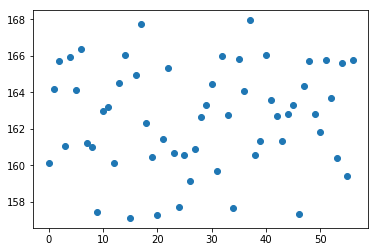

In [49]:
import matplotlib.pyplot as plt
plt.scatter(range(len(output)), output)
plt.show()

In [51]:
import csv
import time
tstr = str(time.time())

with open(tstr+"_blend_mean_predict.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    for i, pred in zip(idx.astype(int), output.astype(int)):
        writer.writerow([i, pred])

In [52]:
a = [1,1,1,2,2,2,3,3,3,4,4,4]
a = np.array(a)
a.reshape(4,-1)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4]])